In [1]:
import numpy as np
import pickle as pcl

from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from methods.training import load_data

from predict import predict

/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cl19abx/Learning_SFHs/venv/lib64/python3

In [2]:
si = predict(fname='data/full_histories_illustris.h5')
se = predict(fname='data/full_histories_eagle.h5')
sv = predict(fname='data/vespa_histories.h5')

eagle_mask, illustris_mask = pcl.load(open('data/sim_selection_masks.p','rb'))

illustris_spec, wl = si.load_spectra('Dust')
eagle_spec, wl = se.load_spectra('Dust')

illustris_spec = illustris_spec[illustris_mask]
eagle_spec = eagle_spec[eagle_mask]

illustris_spec.shape, eagle_spec.shape

((2242, 4601), (916, 4601))

In [3]:
vespa_spec, wl = sv.load_spectra('SDSS')
vespa_mass = sv.load_arr('vespa_mass','Subhalos')

Plot median spectra

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


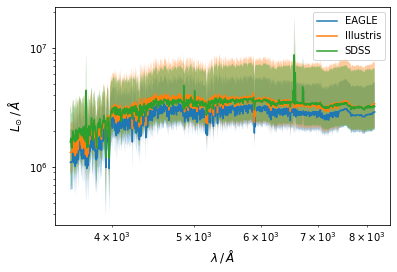

In [4]:
fig = plt.figure()

plt.loglog(wl, np.median(eagle_spec, axis=0), label='EAGLE')
plt.fill_between(wl, np.percentile(eagle_spec, q=16, axis=0), 
                 np.percentile(eagle_spec, q=84, axis=0), alpha=0.4)

plt.loglog(wl, np.median(illustris_spec, axis=0), label='Illustris')
plt.fill_between(wl, np.percentile(illustris_spec, q=16, axis=0), 
                 np.percentile(illustris_spec, q=84, axis=0), alpha=0.4)

plt.loglog(wl, np.median(vespa_spec, axis=0), label='SDSS')
plt.fill_between(wl, np.percentile(vespa_spec, q=16, axis=0), 
                 np.percentile(vespa_spec, q=84, axis=0), alpha=0.4)

plt.ylabel('$L_{\odot} \,/\, \AA$', size=12)
plt.xlabel('$\lambda \,/\, \AA$', size=12)

plt.legend()

# fig.savefig('plots/median_spectra_%s.png'%name, dpi=250, bbox_inches='tight')

## t-SNE

In [13]:
dat = np.log10(np.vstack([illustris_spec, eagle_spec, vespa_spec]))

combined_tsne = TSNE(n_components=2, perplexity=200, n_iter=10000)#12000)# learning_rate=500
combined_tsne = combined_tsne.fit_transform(dat)
combined_tsne.shape

(13158, 2)

In [14]:
len(illustris_spec), len(eagle_spec), len(vespa_spec)

(2242, 916, 10000)

## Plot t-SNE

In [15]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [16]:
M_g = sv.load_arr('g','Magnitudes')
M_r = sv.load_arr('r','Magnitudes')

M_g_illustris = si.load_arr('M_g','Photometry/Dust')[illustris_mask]
M_r_illustris = si.load_arr('M_r','Photometry/Dust')[illustris_mask]

M_g_eagle = se.load_arr('M_g','Photometry/Dust')[eagle_mask]
M_r_eagle = se.load_arr('M_r','Photometry/Dust')[eagle_mask]

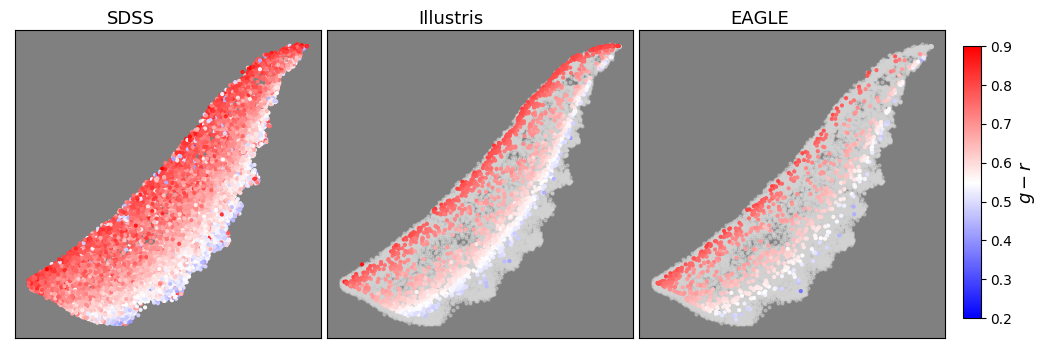

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

fig.subplots_adjust(hspace=.02, wspace=.02)

alpha=0.3
size=4

Ni = len(illustris_spec)
Ne = len(eagle_spec)

cvmin = .2
cvmax = .9

## Colour ##
ax1.scatter(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], 
            alpha=1, s=size, label='SDSS', c=M_g-M_r, vmin=cvmin, vmax=cvmax, cmap='bwr')

for ax in [ax2,ax3]:
    ax.scatter(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], 
            alpha=0.5, s=size, label='SDSS', c='lightgrey')


s = ax2.scatter(combined_tsne[:Ni,0], combined_tsne[:Ni,1], s=size, label='SDSS', 
                c=M_g_illustris-M_r_illustris, alpha=1, cmap='bwr', vmin=cvmin, vmax=cvmax)

s = ax3.scatter(combined_tsne[Ni:(Ni+Ne),0], combined_tsne[Ni:(Ni+Ne),1], s=size, label='SDSS', 
                c=M_g_eagle-M_r_eagle, alpha=1, cmap='bwr', vmin=cvmin, vmax=cvmax)

cax = fig.add_axes([0.915, 0.16, 0.015, 0.68])
plt.colorbar(s, cax=cax).set_label(label='$g-r$', size=13)


ax1.text(0.3, 1.02, 'SDSS', transform=ax1.transAxes, size=13)
ax2.text(0.3, 1.02, 'Illustris', transform=ax2.transAxes, size=13)
ax3.text(0.3, 1.02, 'EAGLE', transform=ax3.transAxes, size=13)


for ax in [ax1,ax2,ax3]:
    ax.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1])
    ax.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('grey')

# fig.savefig('plots/t_SNE.png', dpi=200, bbox_inches='tight')

No handles with labels found to put in legend.


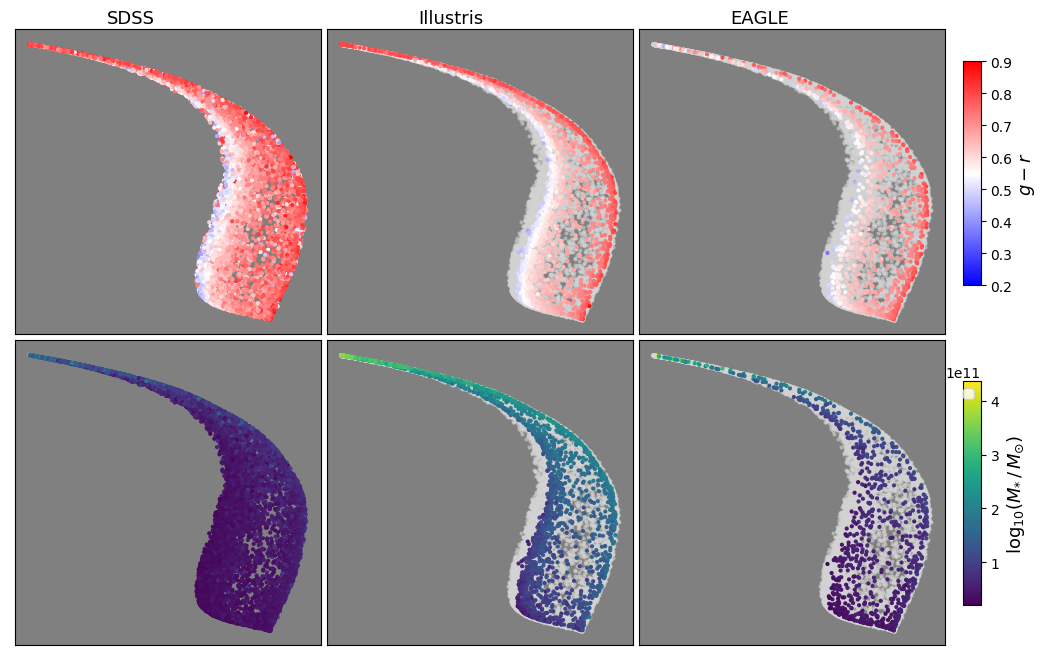

In [50]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(12,8))

fig.subplots_adjust(hspace=.02, wspace=.02)

alpha=0.3
size=4

Ni = len(illustris_spec)
Ne = len(eagle_spec)

cvmin = .2
cvmax = .9

## Colour ##
ax1.scatter(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], 
            alpha=1, s=size, label='SDSS', c=M_g-M_r, vmin=cvmin, vmax=cvmax, cmap='bwr')

for ax in [ax2,ax3,ax5,ax6]:
    ax.scatter(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], 
            alpha=0.5, s=size, label='SDSS', c='lightgrey')
# ax1.hist2d(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], bins=(120,40), cmap='Greys')


s = ax2.scatter(combined_tsne[:Ni,0], combined_tsne[:Ni,1], s=size, label='SDSS', 
                c=M_g_illustris-M_r_illustris, alpha=1, cmap='bwr', vmin=cvmin, vmax=cvmax)

s = ax3.scatter(combined_tsne[Ni:(Ni+Ne),0], combined_tsne[Ni:(Ni+Ne),1], s=size, label='SDSS', 
                c=M_g_eagle-M_r_eagle, alpha=1, cmap='bwr', vmin=cvmin, vmax=cvmax)

cax = fig.add_axes([0.915, 0.56, 0.015, 0.28])
plt.colorbar(s, cax=cax).set_label(label='$g-r$', size=13)


## Stellar Mass ##

mstar = sv.load_arr('vespa_mass','Subhalos')
# mstar = np.log10([value['vespa_mass'] for \
#                   key,value in sq.galaxies.items()])

s = ax4.scatter(combined_tsne[Ni+Ne:,0], combined_tsne[Ni+Ne:,1], 
            s=size, label='SDSS', c=mstar, alpha=1, cmap='viridis')

mstar = si.load_arr('Stellar Mass 30kpc','Subhalos')[illustris_mask]
# mstar = np.log10([value['stellar_mass_30'] for \
#                   key,value in sp.galaxies.items()])[illustris_mask]

s = ax5.scatter(combined_tsne[:Ni,0], combined_tsne[:Ni,1], 
            s=size, label='Illustris', c=mstar, alpha=1, cmap='viridis')

mstar = se.load_arr('Stellar Mass 30kpc','Subhalos')[eagle_mask]
# mstar = np.log10([value['stellar_mass_30'] for \
#                   key,value in sr.galaxies.items()])[eagle_mask]

s = ax6.scatter(combined_tsne[Ni:(Ni+Ne),0], combined_tsne[Ni:(Ni+Ne),1], 
            s=size, label='EAGLE', c=mstar, alpha=1, cmap='viridis')

cax = fig.add_axes([0.915, 0.16, 0.015, 0.28])
plt.colorbar(s, cax=cax).set_label(label='$\mathrm{log_{10}}(M_{*} \,/\, M_{\odot})$', size=13)


ax1.text(0.3, 1.02, 'SDSS', transform=ax1.transAxes, size=13)
ax2.text(0.3, 1.02, 'Illustris', transform=ax2.transAxes, size=13)
ax3.text(0.3, 1.02, 'EAGLE', transform=ax3.transAxes, size=13)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_ylim(ax2.get_ylim()[0], ax2.get_ylim()[1])
    ax.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor('grey')

# fig.savefig('plots/t_SNE.png', dpi=250, bbox_inches='tight')